In [1]:
%matplotlib inline

In [2]:
# Import python modules
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, MultiPoint, Polygon
from sklearn.gaussian_process.kernels import Matern
from shapely.wkt import loads
from scipy.spatial.ckdtree import cKDTree
import matplotlib.pyplot as plt
import netCDF4
import h5py
import gc, sys, os
sys.path.append("../scripts")
import spatial_functions
import aem_utils
import netcdf_utils
import modelling_utils
import plotting_functions as plots
import warnings
import numpy.ma as ma
warnings.filterwarnings('ignore')

In [3]:
aem_nc_path = infile = r"C:\Users\PCUser\Desktop\AEM\AusAEM\AusAEM_02_GA_layer_earth_inversion\vectorsum\tranche1\AusAEM_02_NT&WA_AEM_Tranche1_GA_vsum_inversion.nc"

aaem = aem_utils.AEM_inversion(name = 'AusAEM (galeisbstdem)',
                               inversion_type = 'deterministic',
                               netcdf_dataset = netCDF4.Dataset(aem_nc_path))

In [6]:
# Bring in the palaeovalleys

infile = r"C:\Users\PCUser\Desktop\EFTF2\vector\AquifersNGIS\AquiferNGIS_z52.shp"

gdf_aqu = gpd.read_file(infile)

# Convert to gda zone 52
#gdf_aqu = gdf_aqu.to_crs("EPSG:28352")

In [47]:
# Our first item is the palaeovalley
pv = Polygon(gdf_aqu.iloc[210].geometry[-1])
pv

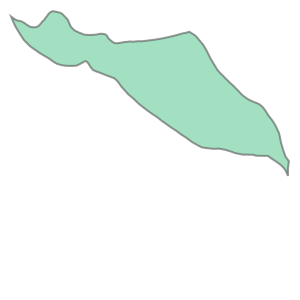

In [183]:
lg = Polygon(gdf_aqu.iloc[13].geometry[0])
lg

In [ ]:
gg = Polygon(gdf_aqu.iloc[13].geometry[0])
gg

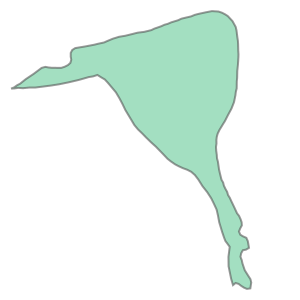

In [188]:
cl= Polygon(gdf_aqu.iloc[12].geometry[0])
cl

In [187]:

for i in range(1110):
    x,y = 385550, 7850000
    cl = Polygon(gdf_aqu.iloc[12].geometry[i])
    if Point(x,y).within(cl):
        print(i)
        break

0


In [185]:
gg = Polygon(gdf_aqu.iloc[13].geometry[2])
Point(x,y).within(gg)

False

In [ ]:
wb = Polygon(gdf_aqu.iloc[137].geometry)
wb

In [115]:
# Now we have the lines we can grid the lci conductivity data onto vertical grids (known as sections)
# this is the easiest way to visualise the AEM conuctivity in 2-dimensions

# Assign the lci variables to grid
grid_vars = ['conductivity', 'phid']

# Define the resolution of the sections
xres, yres = 50., 5.

lines = [5001001,  5001002,  5001003,
                    5002001,  5002002,  5002003,  5003002,  5003003,
                    5004002,  5004003,  5004004,  5005002,  5005003,
                    5005004,  5005005,  5006001,  5006002,  5006003,
                    5007002,  5007003,  5007004,  5008001,  5008002,
                    5009001,  5009002,  5009003,  5010001,  5010002,
                    5011002,  5011003,  5011004,  5011005,  5012002,
                    5012003,  5012004,  5013001,  5013002,  5013003,
                    5014001,  5014002,  5015001,  5015002,  5015003,
                    5015004,  5016001,  5016002,  5016003,  5017001,
                    5017002,  5017003,  4006001,  6003002,  6005001]

# Define the output directory if saving the grids as hdf plots

hdf5_dir = r"C:\Users\PCUser\Desktop\AEM\AusAEM\AusAEM_02_GA_layer_earth_inversion\vectorsum\tranche1\hdf5"

# if the directory doesn't exist, then create it
if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)  

# Gridding takes a few minutes so I pre-gridded them for you. The lci.grid_sections()
# function below will do the gridding for you. Instead we will use the load_sectoin_from_file()
# function, which loads hdf5 files produced using the grid_sections() function


#aaem.grid_sections(variables = grid_vars, lines = lines, xres = xres, yres = yres,
#                  return_interpolated = True, save_hdf5 = True, hdf5_dir = hdf5_dir)


aaem.load_sections_from_file(hdf5_dir, grid_vars)

In [124]:
def dist_2_east_ticks(ax, section_data):
    east_ticks = ax.get_xticks().copy()


    for i, t in enumerate(east_ticks):
        mask = np.where(np.isclose(section_data['grid_distances'],t))[0]
        easting = section_data['easting'][mask]
        if len(easting) > 0:
            east_ticks[i]= np.round(easting[0],1)
        else:
            east_ticks[i]= np.nan

    ax.set_xticklabels(east_ticks)

4006001


No handles with labels found to put in legend.


5001001


No handles with labels found to put in legend.


5001002
5001003


No handles with labels found to put in legend.


5002001


No handles with labels found to put in legend.


5002002
5002003


No handles with labels found to put in legend.


5003002
5003003


No handles with labels found to put in legend.


5004002


No handles with labels found to put in legend.


5004003
5004004


No handles with labels found to put in legend.


5005002
5005003


No handles with labels found to put in legend.


5005004


No handles with labels found to put in legend.


5005005


No handles with labels found to put in legend.


5006001
5006002


No handles with labels found to put in legend.


5006003
5007002
5007003
5007004


No handles with labels found to put in legend.


5008001
5008002
5009001
5009002
5009003
5010001
5010002
5011002
5011003
5011004
5011005
5012002
5012003
5012004
5013001
5013002
5013003
5014001
5014002
5015001
5015002
5015003
5015004
5016001
5016002
5016003
5017001
5017002
5017003


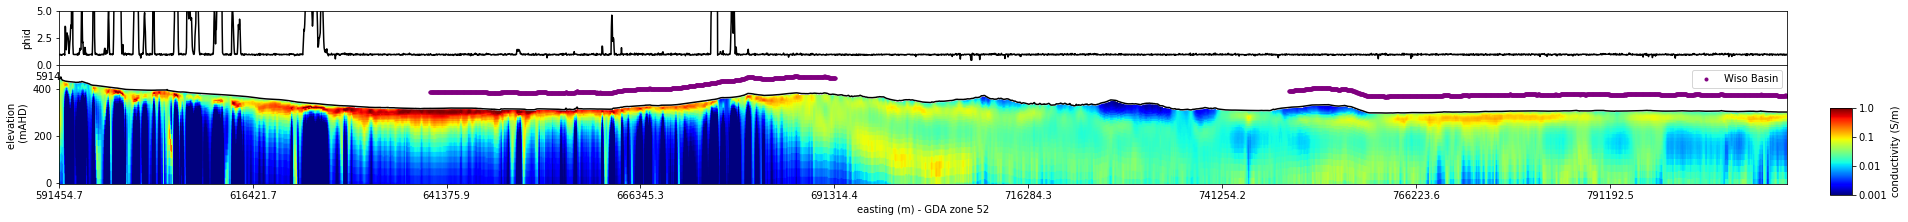

In [191]:
outdir = r"C:\Users\PCUser\Desktop\EFTF2\HTC\AEM_viz"

for line in aaem.section_data.keys():
    print(line)
    plt.close('all')
    fig = plt.figure(figsize = (30,3))

    # Add two axes for the data misfit and the conductivity
    # 
    ax1 = fig.add_axes([0.1, 0.7, 0.8, 0.25])
    ax2 = fig.add_axes([0.1, 0.15, 0.8, 0.55], sharex = ax1)

    # Add a color
    cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.4])

    panel_kwargs = [{'title': '',
                          'color': 'black',
                          'ylabel': 'phid',
                          'legend': False,
                          },
                         {'max_depth': 300.,
                          'shade_doi': False,
                          'colourbar': True,
                          'colourbar_label': 'Conductivity (S/m)',
                          'log_plot': True,
                          'vmin': 0.001,
                          'vmax': 1.,
                          'cmap': 'jet',
                          'ylabel': 'elevation \n (mAHD)'}]

    res = plots.plot_single_line(ax1, aaem.section_data[line],
                                       'phid', panel_kwargs[0])

    ax1.set_ylim(0,5)

    cond_section = plots.plot_grid(ax2, aaem.section_data[line], 'conductivity',
                               panel_kwargs[1])

    cb = fig.colorbar(cond_section, cax=cbar_ax, orientation='vertical')

    cbar_ax.set_yticklabels([round(10 ** x, 4) for x in cb.get_ticks()])

    cb.set_label('conductivity (S/m)', fontsize=10)

    # Now plot the palaeovalley points
    
    cols = ['darkkhaki', 'lightskyblue', 'green', 'blue', 'purple']
    name = ['palaeovalley aquifer', 'Liveringa group', 'Grant Group', 'Canning Limestone', 'Wiso Basin']
    count = 0
    for i, item in enumerate(['pv_mask', 'lg_mask', 'gg_mask', 'cl_mask', 'wb_mask']):

        mask = aaem.section_data[line][item]
        
        
        if mask.sum() > 0:
            dist = aaem.section_data[line]['grid_distances'][mask]
            elev = aaem.section_data[line]['elevation'][mask] + 70 - count*20
            count += 1

            ax2.scatter(dist, elev, marker = '.', c = cols[i], label = name[i])
    ax2.legend()
    ax2.set_xlabel('easting (m) - GDA zone 52')
    # Add the easting on the xaxis
    dist_2_east_ticks(ax2, aaem.section_data[line])
    
    outfile = os.path.join(outdir, str(line) + '.png')
    plt.savefig(outfile, dpi = 200)
    gc.collect()


In [82]:
elev.shape

(1468,)

In [189]:
for line in aaem.section_data.keys():
    print(line)
    easting = aaem.section_data[line]['easting']
    northing = aaem.section_data[line]['northing']
    #mask = np.array([pv.contains(Point(x, y)) for x, y in np.column_stack((easting, northing))])
    #aaem.section_data[line]['pv_mask'] = mask
    #mask = np.array([lg.contains(Point(x, y)) for x, y in np.column_stack((easting, northing))])
    #aaem.section_data[line]['lg_mask'] = mask
    mask = np.array([gg.contains(Point(x, y)) for x, y in np.column_stack((easting, northing))])
    aaem.section_data[line]['gg_mask'] = mask
    mask = np.array([cl.contains(Point(x, y)) for x, y in np.column_stack((easting, northing))])
    aaem.section_data[line]['cl_mask'] = mask
    gc.collect()

4006001
5001001
5001002
5001003
5002001
5002002
5002003
5003002
5003003
5004002
5004003
5004004
5005002
5005003
5005004
5005005
5006001
5006002
5006003
5007002
5007003
5007004
5008001
5008002
5009001
5009002
5009003
5010001
5010002
5011002
5011003
5011004
5011005
5012002
5012003
5012004
5013001
5013002
5013003
5014001
5014002
5015001
5015002
5015003
5015004
5016001
5016002
5016003
5017001
5017002
5017003


In [70]:
print(line)

5010001
